Installation
```
pip install spacy_experimental
pip install chardet
pip install thinc[torch]
pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl
```


In [1]:
import spacy
import pandas as pd
import sqlite3
import os
from dotenv import load_dotenv
import sys
import matplotlib.pyplot as plt
load_dotenv()

True

In [2]:
nlp_coref = spacy.load("en_coreference_web_trf")

In [6]:
doc = nlp_coref("My dad passed away last summer after suffering from the behavioral variant FTD, he was older when he was diagnosed but he probably had it longer but we probably missed a lot of signs over the years. When the symptoms really started getting bad that's when my dad's doctor ordered an MRI and we learned that the frontal part of his brain was shrinking and in atrophy.  For my dad, from diagnosis to death it took less than two years, a year and nine and a half months to be exact.    As another poster mentioned I wrote a journal of everything he went through and it was challenging for sure as my mother and I were his caregivers the entire time.  If there was one blessing it was that he never lost his memory of who my mom and I were so that was a good thing.  I could write a book here on what we went through with this disease but almost seven months since his passing, I wish I could take care of him for just one more day.")
print(doc.spans)
print(type(doc.spans.get("coref_clusters_1")))
s = doc.spans.get("coref_clusters_1")
print(s)

{'coref_clusters_1': [My dad, he, he, he, my dad's, his, my dad, he, his, he, his, his, him], 'coref_clusters_2': [the behavioral variant FTD, it, this disease], 'coref_clusters_3': [passed, that, diagnosis to death, his passing], 'coref_clusters_4': [My, my, my, I, my, I, my, I, I, I, I], 'coref_clusters_5': [wrote, it], 'coref_clusters_6': [one blessing, it], 'coref_clusters_7': [my mother, my mom, we], 'coref_clusters_8': [lost, that]}
<class 'spacy.tokens.span_group.SpanGroup'>
[My dad, he, he, he, my dad's, his, my dad, he, his, he, his, his, him]


In [47]:
type(doc)

spacy.tokens.doc.Doc

In [9]:
doc = nlp_coref("Dr. PERSON, mom is behaving the opposite way. She lives in an assisted living facility and she is pushing the call button every few minutes to have them hand her the remote when it is sitting right next to her, wanting them to wipe her when she goes to the bathroom and many other things like that. The caregivers are so frustrated and the nurse is trying to get her to do these things for herself while she still can. I am frustrated and can’t be around her because I am just so exhausted and I feel like her slave. What is your advice?")
print(doc.spans)

{'coref_clusters_1': [mom, She, she, her, her, her, she, her, herself, she, her, her], 'coref_clusters_2': [the remote, it], 'coref_clusters_3': [them, them], 'coref_clusters_4': [Dr. PERSON, I, I, I, your]}


In [46]:
doc = nlp_coref("""Yes but it all depends on the state of dementia of your LO. Anything I try to say, request her to do or discuss with my mother is met with hostility. She is deeply paranoid and suspicious. She makes unfounded and quite horrid accusations to and about me. She argues with me even when I am being nice to her. She argues about her arguing!!! Bascially I am her punch bag and it is soul destroying. If you haven't already get a PoA and do what you have to do without them making it harder for you. If day to day tasks become impossible to complete then get home help for assistance or check your LO into a care facility. There comes a point when the stress and aggravation is just not worth it. They have dementia what do they know? Many times I feel like my mother is frying my brain and it literally hurts my head and I just want out. Can't do it any more, but I am trapped and she knows it because as well as having dementia she is a manipulative selfish narcissist which is a terrible combination. Get help is all I can say. Trying to deal with contentious issues on a one to one basis with a LO who is resistant non compliant is, 99% of the time, going to fail.""")
print(doc.spans)

{'coref_clusters_1': [I, my, me, me, I, I, I, my, my, my, I, I, I], 'coref_clusters_2': [her, my mother, She, She, She, her, She, her, her, my mother, she, she], 'coref_clusters_3': [am, it], 'coref_clusters_4': [They, they], 'coref_clusters_5': [frying, it], 'coref_clusters_6': [am, it]}


In [11]:
doc = nlp_coref("""We embraced my husband's dementia because.... it is what it is.   When he first got the diagnosis we were mostly relieved, better than the dramas and psychosis that plagued him for a few years.   That had been a miserable time and I was his target.   Knowing what it was,  made our lives better.

We ended up with a good medical team, the right meds after a few months of trials, government pension,  did all the legal paperwork while he could still function and we told people what he had with no shame or hesitation.

7 years down with him at a moderate to severe stage and him sitting most days with his own thoughts, I think maybe his life is not so bad, no decisions, no bills, no driving, no responsibility,  not answerable for anything...... perpetual holiday of the mind.  It's then I think he's the lucky one.   I just get the work.
"""
)
print(doc.spans)

{'coref_clusters_1': [my husband's dementia, it, it, it], 'coref_clusters_2': [my husband's, he, him, his, he, he, him, him, his, his, he], 'coref_clusters_3': [We, we, our, We, we], 'coref_clusters_4': [my, I, I, I, I]}


# Identify Knowledgable Informant 


### Proposed NLP Pipeline
1. Remove single sentence comments
2. NER, replace names
3. Remove thank you's
4. Apply coreference pipeline


### Proposed Methodology
1. Sort most common head coref clusters of interest (start w/ my then a word...). Count them, calculate distribution of length of references.
2. Create list of relevant coref cluster heads.
3. Determine threshold for "talking about self". What is length of "I" (knowledgeable informant) vs. the patient?

In [3]:

comments = pd.read_sql("SELECT ROWID, * FROM comments", sqlite3.connect(os.path.join("..", "data", os.environ["SQLITE_DB_NAME"])))

True

In [13]:
print(comments.shape)
sys.getsizeof(comments) / 1024**3 # GB

(232214, 13)


0.25164382439106703

In [45]:
nlp_sm = spacy.load("en_core_web_sm")

c:\Users\david\anaconda3\envs\spacy_experimental\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Initial Filtering Dataset
Reduce dataset size before apply compute heavy coref.

In [15]:
# Reduce Before Applying Coref
#### Filtering Criteria
comments["sentence_count"] = comments["comment_text"].apply(lambda x: len(list(nlp_sm(x).sents)))
filter_1 = (comments.is_reply == 0)
# filter_2 = (comments.reply_by_channel_owner == 0) redudant
filter_3 = (comments.sentence_count) > 1

filters = [
    ('remove replies', filter_1),
    ('remove comments with only one sentence', filter_3)
]

filtered = comments.copy()
for name, bool_srs in filters:
    orig_rows = filtered.shape[0]
    filtered = filtered.loc[bool_srs, :]
    updated_rows = filtered.shape[0]
    print(f"{name}: {orig_rows} -> {updated_rows} ({updated_rows / orig_rows:.2%})")

filtered.to_pickle(os.path.join("..", "data", "filtered_comments.pkl"))

remove replies: 232214 -> 179816 (77.44%)
remove replies by channel owner: 179816 -> 179816 (100.00%)
remove comments with only one sentence: 179816 -> 87476 (48.65%)


In [27]:
filtered.comment_text.sample(10)

215671    I understand what you going through. keep the ...
3450      Yes I have.  Just recently.  Good resource for...
162735    Would love to hear her on a decent piano. That...
10660     OMG all of them!!!! But then I looked at the p...
160900    Is it out of tune?...I forgot how a perfectly ...
61022     Doc… I love you man, but vegetable carbohydrat...
87825     My grandma has dementia..her memory lasts like...
114940    even though she’s and actress, i HATE that bit...
10805     Yes, going to make a binder for myself and my ...
103976    Why do some people scratch their heads when th...
Name: comment_text, dtype: object

### Apply Coreference Resolution

In [3]:
filtered = pd.read_pickle(os.path.join("..", "data", "filtered_comments.pkl"))
database_path = os.path.join("..", "data", os.environ["SQLITE_DB_NAME"])
conn = sqlite3.connect(database_path)

# iterate over filtered in batches
batch_size = 1000
for i in range(0, filtered.shape[0], batch_size):
    print(f"Processing {i} to {i+batch_size}, {i / filtered.shape[0]:.2%}")
    batch = filtered.iloc[i:i+batch_size, :].copy()
    batch["coref_result"] = batch["comment_text"].apply(lambda x: nlp_coref(x))
    batch["coref_result_json"] = batch["coref_result"].apply(lambda x: str(x.to_json()))
    batch["coref_spans_json"] = batch["coref_result"].apply(lambda x: str(x.spans))
    batch["coref_doc_bytes"] = batch["coref_result"].apply(lambda x: x.to_bytes())
    batch.rename(columns={"rowid": "comment_rowid"}, inplace=True)
    batch.drop(columns=[c for c in batch.columns if c not in ["comment_rowid", "coref_result_json", "coref_spans_json", "coref_doc_bytes"]], inplace=True)
    batch.to_sql(con=conn, name="comments_coref", if_exists="append", index=False)


Processing 0 to 1000, 0.00%
Processing 1000 to 2000, 1.14%
Processing 2000 to 3000, 2.29%


Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors


Processing 3000 to 4000, 3.43%
Processing 4000 to 5000, 4.57%
Processing 5000 to 6000, 5.72%
Processing 6000 to 7000, 6.86%
Processing 7000 to 8000, 8.00%
Processing 8000 to 9000, 9.15%
Processing 9000 to 10000, 10.29%
Processing 10000 to 11000, 11.43%
Processing 11000 to 12000, 12.57%
Processing 12000 to 13000, 13.72%
Processing 13000 to 14000, 14.86%
Processing 14000 to 15000, 16.00%
Processing 15000 to 16000, 17.15%
Processing 16000 to 17000, 18.29%
Processing 17000 to 18000, 19.43%
Processing 18000 to 19000, 20.58%
Processing 19000 to 20000, 21.72%
Processing 20000 to 21000, 22.86%
Processing 21000 to 22000, 24.01%
Processing 22000 to 23000, 25.15%
Processing 23000 to 24000, 26.29%
Processing 24000 to 25000, 27.44%
Processing 25000 to 26000, 28.58%
Processing 26000 to 27000, 29.72%
Processing 27000 to 28000, 30.87%
Processing 28000 to 29000, 32.01%
Processing 29000 to 30000, 33.15%
Processing 30000 to 31000, 34.30%
Processing 31000 to 32000, 35.44%
Processing 32000 to 33000, 36.58%

### Load Coref Results

In [52]:
database_path = os.path.join("..", "data", os.environ["SQLITE_DB_NAME"])
conn = sqlite3.connect(database_path)

comments_coref = pd.read_sql("SELECT * FROM comments_coref", conn)
comments_coref["coref_result"] = comments_coref["coref_doc_bytes"].apply(lambda x: spacy.tokens.doc.Doc(nlp_coref.vocab).from_bytes(x))

: 

In [7]:

def unpack_coref_to_tokens(row):
    lst = []
    all_coref_chains = row["coref_result"].spans
    for span in all_coref_chains:
        span_index = span.split("_")[-1]
        for j, ent in enumerate(all_coref_chains[span]):
            p = nlp_sm(ent.text)
            s = next(p.sents)

            possessive_tup = None
            possessive_lemma = None
            root_tup = None
            root_first = True
            root_lemma = None
            compressed_possessive = None
            compressed_possessive_lemma = None

            for i, t in enumerate(s):
                if t.dep_ == "poss" and t.pos_ == "PRON":
                    possessive_tup = (t.text, i)
                    possessive_lemma = t.lemma_
                elif t.dep_ == "ROOT":
                    root_tup = (t.text, i, t.pos_)
                    root_lemma = t.lemma_
            if root_tup is not None and possessive_tup is not None:
                root_first = root_tup[1] < possessive_tup[1]
                if root_first:
                    compressed_possessive = root_tup[0] + " " + possessive_tup[0] 
                    compressed_possessive_lemma = root_lemma + " " + possessive_lemma
                else:
                    compressed_possessive = possessive_tup[0] + " " + root_tup[0]
                    compressed_possessive_lemma = possessive_lemma + " " + root_lemma
                    
                
            row_dict = {
                "comment_rowid": row["comment_rowid"],
                "ref_chain_index": span_index,
                "ref_index": j,
                "original_token": ent.text,
                "lower_token": ent.text.lower(),
                "root": s.root.text,
                "root_lemmatized": root_lemma,
                "root_pos": root_tup[2] if root_tup is not None else None ,
                "compressed_possessive": compressed_possessive,
                "compressed_possessive_lemmatized": compressed_possessive_lemma
            }
            lst.append(row_dict)
    return lst

In [8]:
for i, row in comments_coref.iterrows():
    lst = unpack_coref_to_tokens(row)
    if i == 0:
        df = pd.DataFrame(lst)
    else:
        df = pd.concat([df, pd.DataFrame(lst)])

In [10]:

df["final_token"] = df["compressed_possessive_lemmatized"].fillna(df["root_lemmatized"]).str.lower()
df["final_token_len"] = df["final_token"].str.len()
df["within_chain_max_len"] = df.groupby(["comment_rowid", "ref_chain_index"])["final_token_len"].transform(lambda x: x.max())


In [11]:
df["chain_len"] = df.groupby(["comment_rowid", "ref_chain_index"])["final_token_len"].transform(lambda x: x.count())

In [12]:
df['chain_i_count'] = df.groupby(["comment_rowid", "ref_chain_index"])['final_token'].transform(lambda x: x[x == 'i'].count())

In [14]:
df.shape

(723633, 15)

In [51]:
a = nlp_sm("my husband is a person")
a.is_nered

C:\Users\david\AppData\Local\Temp\ipykernel_29888\2134857202.py:2: DeprecationWarning: [W107] The property `Doc.is_nered` is deprecated. Use `Doc.has_annotation("ENT_IOB")` instead.
  a.is_nered


True

In [ ]:
df.to_pickle(os.path.join("..", "data", "coref_chain_tokens.pkl"))

In [2]:
df = pd.read_pickle(os.path.join("..", "data", "coref_chain_tokens.pkl"))

In [3]:
df.head(10)

,comment_rowid,ref_chain_index,ref_index,original_token,lower_token,root,root_lemmatized,root_pos,compressed_possessive,compressed_possessive_lemmatized,final_token,final_token_len,within_chain_max_len,chain_len,chain_i_count
0,1,1,0,My,my,My,my,PRON,None,None,my,2.0,2.0,15,12
1,1,1,1,I,i,I,I,PRON,None,None,i,1.0,2.0,15,12
2,1,1,2,I,i,I,I,PRON,None,None,i,1.0,2.0,15,12
3,1,1,3,I,i,I,I,PRON,None,None,i,1.0,2.0,15,12
4,1,1,4,I,i,I,I,PRON,None,None,i,1.0,2.0,15,12
5,1,1,5,My,my,My,my,PRON,None,None,my,2.0,2.0,15,12
6,1,1,6,I,i,I,I,PRON,None,None,i,1.0,2.0,15,12
7,1,1,7,me,me,me,I,PRON,None,None,i,1.0,2.0,15,12
8,1,1,8,me,me,me,I,PRON,None,None,i,1.0,2.0,15,12
9,1,1,9,I,i,I,I,PRON,None,None,i,1.0,2.0,15,12


In [4]:
comment_chains = df.groupby(["comment_rowid"]).agg({"ref_chain_index": "max", "chain_len": ["min", "median", "max"]})

In [9]:
comment_chains.columns

MultiIndex([('ref_chain_index',    'max'),
            (      'chain_len',    'min'),
            (      'chain_len', 'median'),
            (      'chain_len',    'max')],
           )

In [5]:
comment_chains.columns = comment_chains.columns.to_flat_index()
# merge column index to one column
comment_chains.columns = ["_".join(x) for x in comment_chains.columns]
comment_chains["ref_chain_index_max"] = comment_chains["ref_chain_index_max"].astype(float)

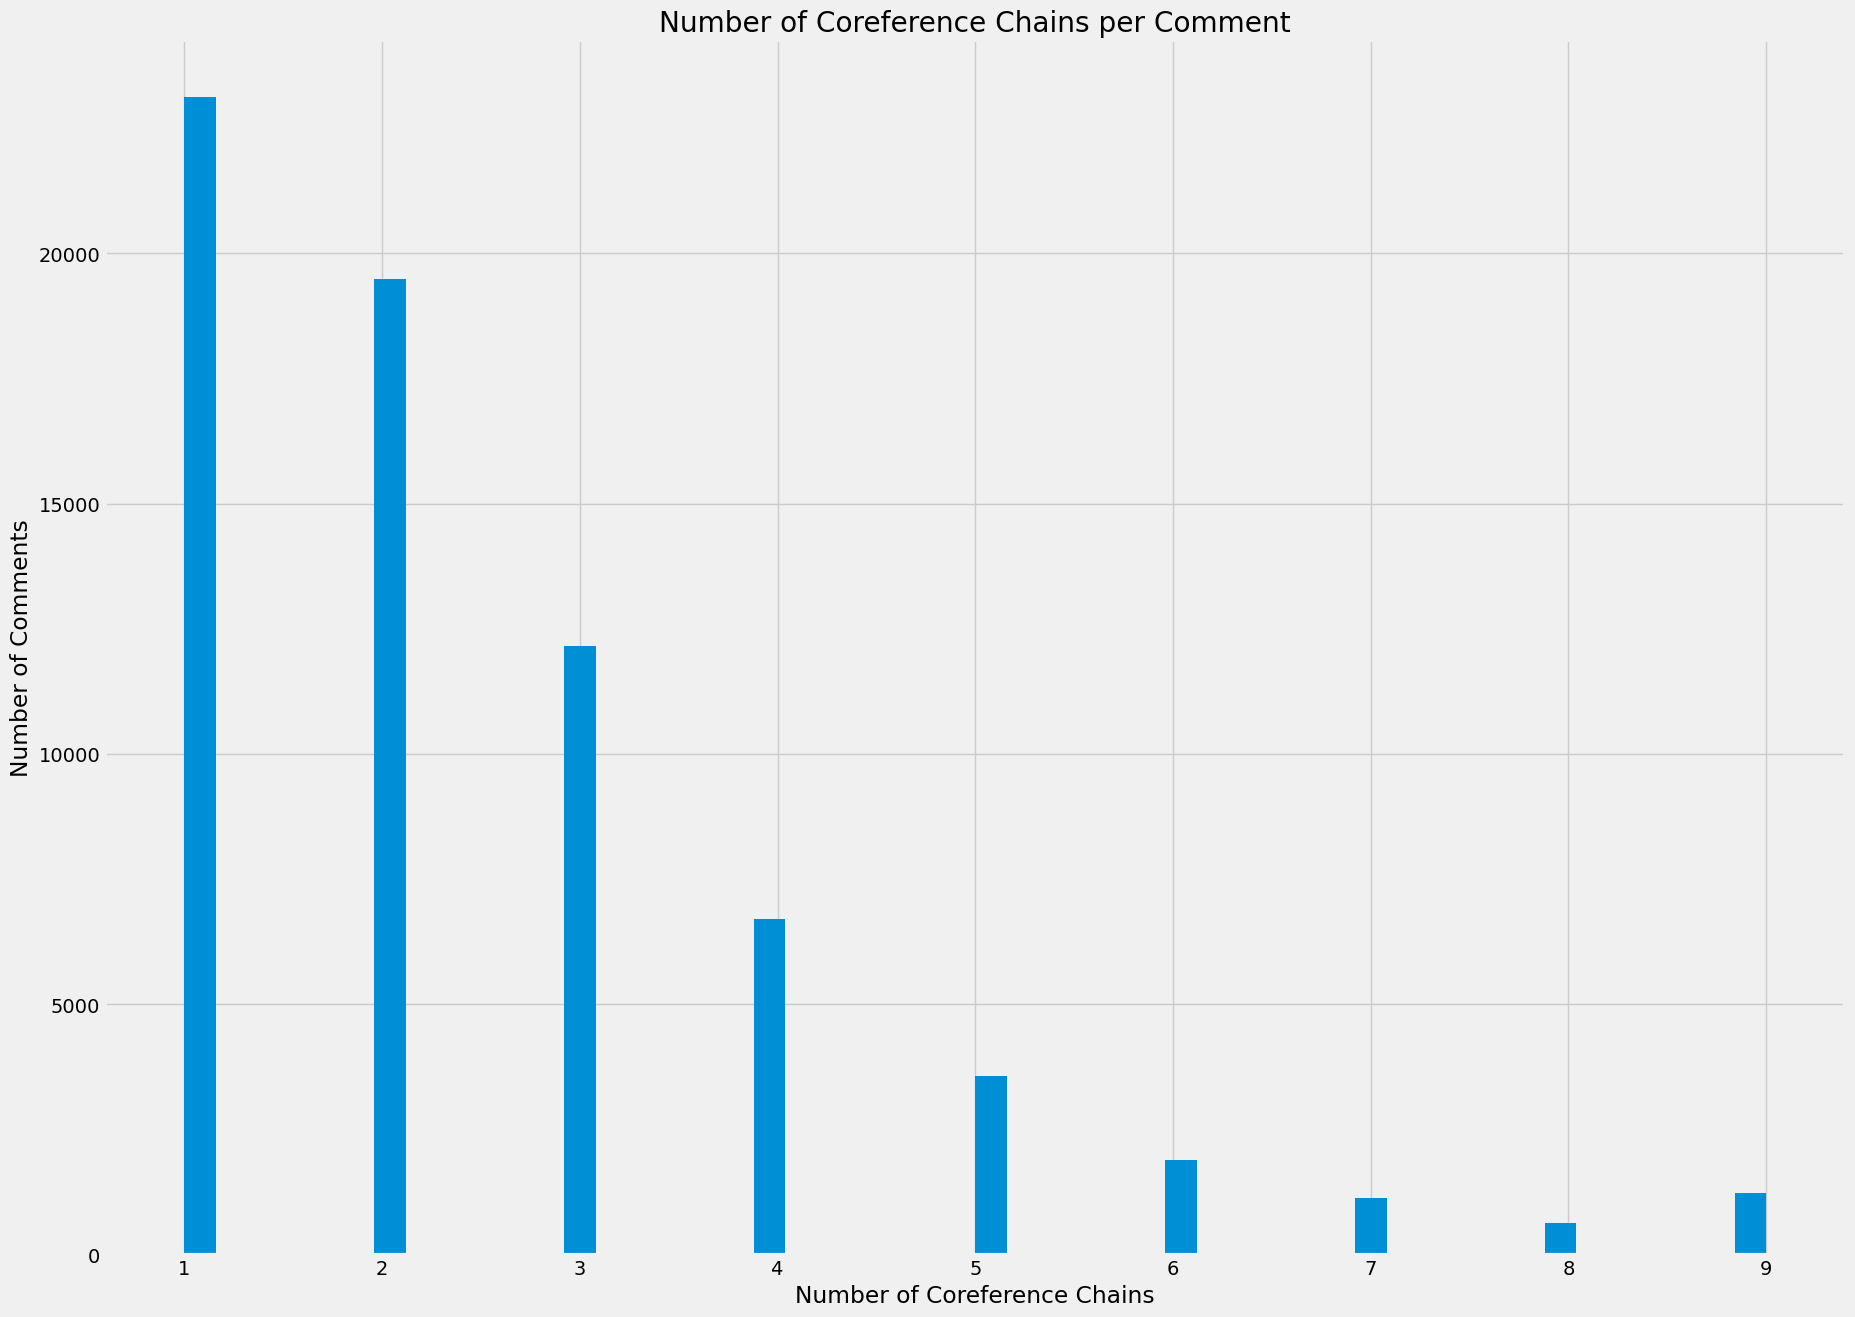

In [8]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
comment_chains[("ref_chain_index_max")].plot.hist(bins=50, figsize=(20,15))
plt.title("Number of Coreference Chains per Comment")
plt.xlabel("Number of Coreference Chains")
plt.ylabel("Number of Comments")
plt.style.use("ggplot")

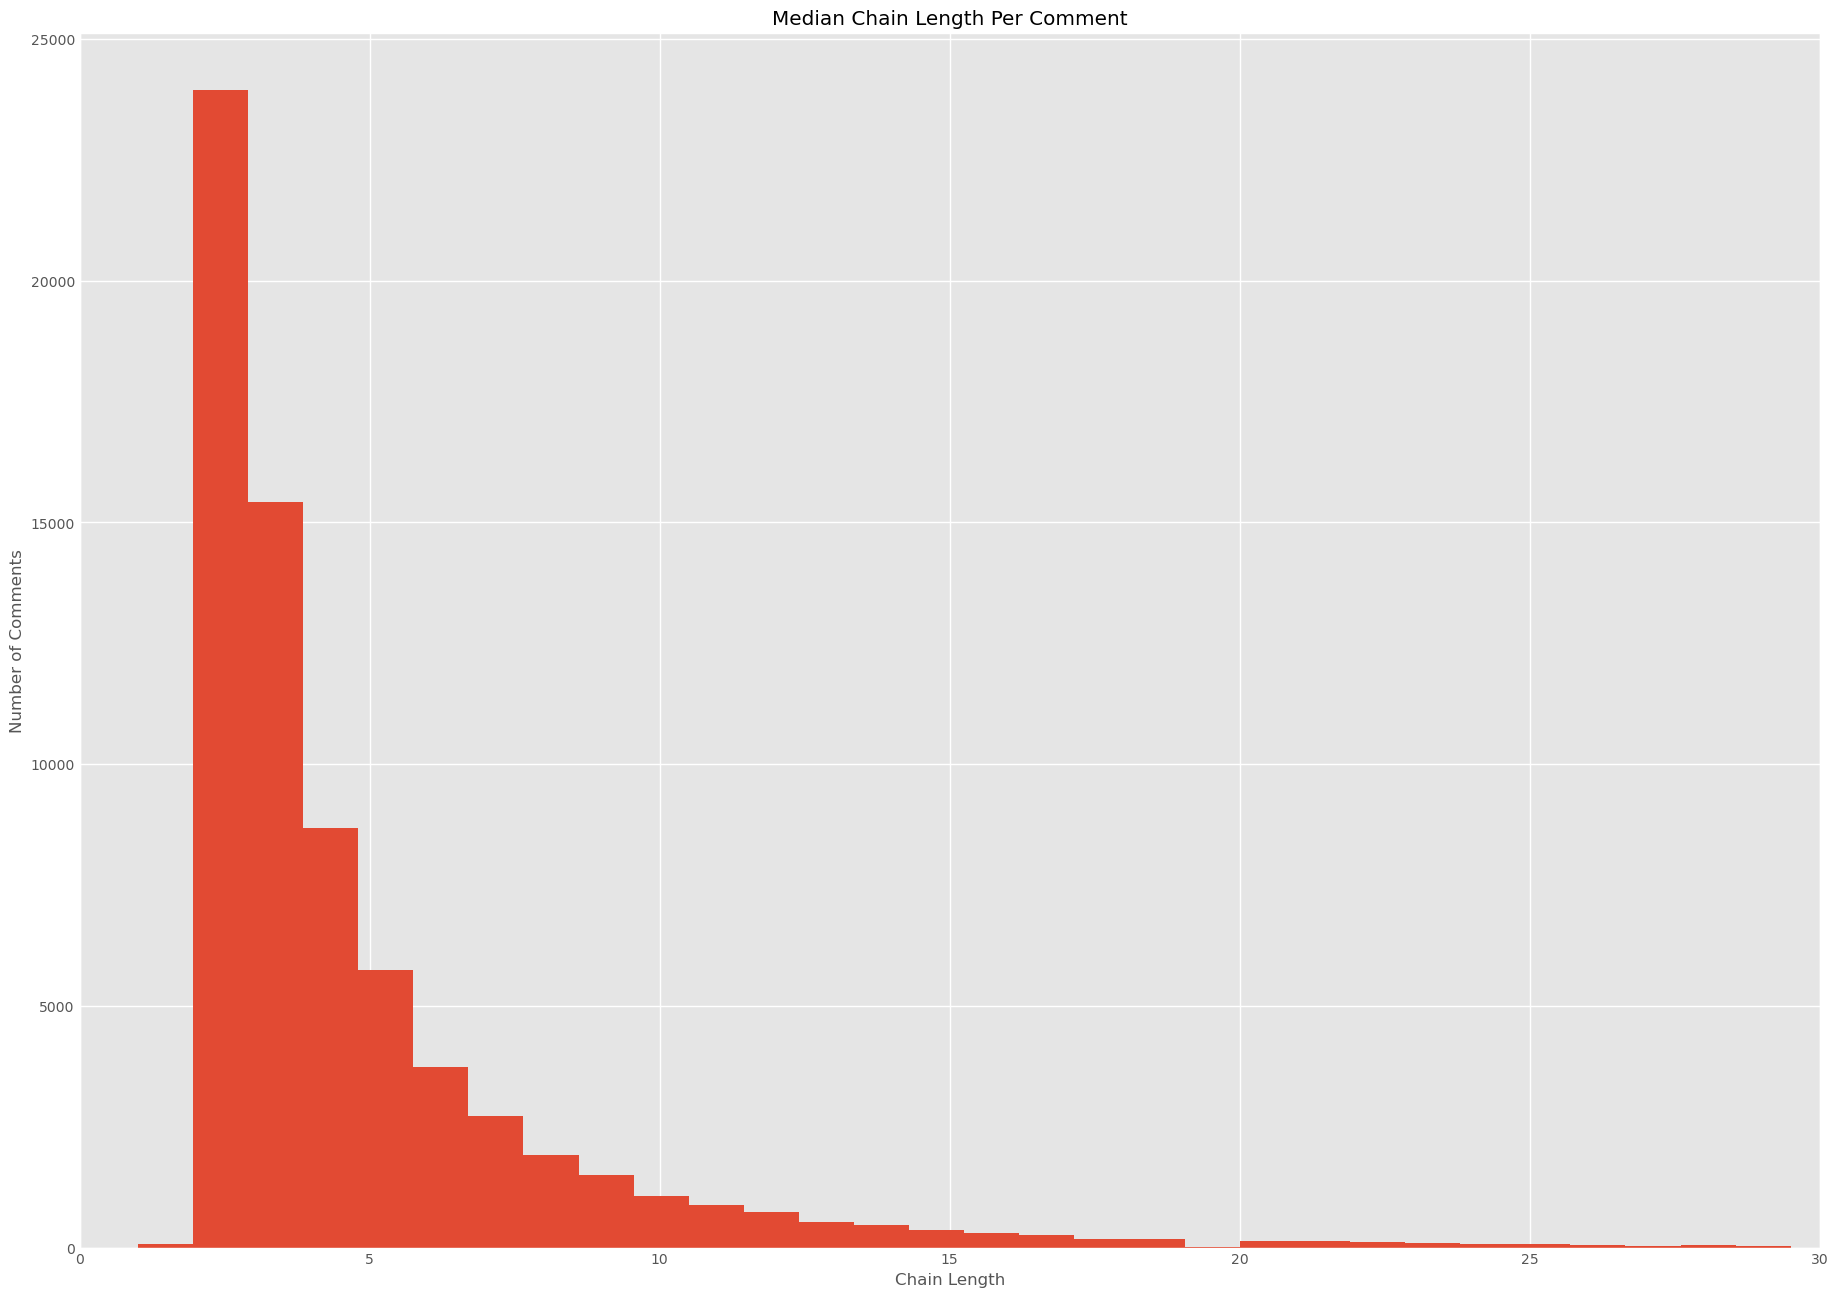

In [9]:
comment_chains.loc[(comment_chains[("chain_len_median")] < 30), ("chain_len_median")].plot.hist(bins=30, figsize=(20,15))
plt.title("Median Chain Length Per Comment")
plt.xlabel("Chain Length")
plt.ylabel("Number of Comments")
plt.xlim(0, 30)
plt.style.use("ggplot")

In [52]:
# assume the longest token in a chain is coref chain principal entity
# if two tokens have same length, keep them both
# root token is a noun, not a pronoun
### Noun requirement filters out I, you, we, our, my...
df_chains_w_nouns = df.loc[df.root_pos.isin(["NOUN", "PROPN"]), :].copy()

#df_chain_head.loc[df_chain_head.final_token.str.contains("mom|dad|father|mother|grand")].groupby(["final_token"])["lower_token"].value_counts().sort_values(ascending=False).to_excel(os.path.join("..", "data", "occurences_chain_head_family.xlsx"))

In [53]:
df_chains_w_nouns

,comment_rowid,ref_chain_index,ref_index,original_token,lower_token,root,root_lemmatized,root_pos,compressed_possessive,compressed_possessive_lemmatized,final_token,final_token_len,within_chain_max_len,chain_len,chain_i_count
15,1,2,0,My 64 year old husband,my 64 year old husband,husband,husband,NOUN,My husband,my husband,my husband,10.0,10.0,11,1
17,1,2,2,My husband,my husband,husband,husband,NOUN,My husband,my husband,my husband,10.0,10.0,11,1
24,1,2,9,My husband,my husband,husband,husband,NOUN,My husband,my husband,my husband,10.0,10.0,11,1
28,1,4,0,an attorney,an attorney,attorney,attorney,NOUN,None,None,attorney,8.0,8.0,2,0
33,1,6,0,FTD,ftd,FTD,FTD,PROPN,None,None,ftd,3.0,7.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,232171,1,0,PERSON,person,PERSON,person,NOUN,None,None,person,6.0,6.0,2,0
1,232171,1,1,PERSON,person,PERSON,person,NOUN,None,None,person,6.0,6.0,2,0
3,232177,2,0,PERSON,person,PERSON,person,NOUN,None,None,person,6.0,6.0,3,0
1,232191,1,1,️,️,️,️,PROPN,None,None,️,1.0,1.0,2,0


In [59]:
starts_with_my = df_chains_w_nouns.final_token.str[0:2] == "my"
df_final_token = df_chains_w_nouns.loc[starts_with_my].groupby(["final_token"]).agg(
    {
        "comment_rowid": "nunique",
        "chain_len": ("min", "median", "max"),
        "chain_i_count": "median"
    }
)
df_final_token.columns = df_final_token.columns.to_flat_index()
df_final_token.columns = ["_".join(x) for x in df_final_token.columns]
df_final_token.columns

Index(['comment_rowid_nunique', 'chain_len_min', 'chain_len_median',
       'chain_len_max', 'chain_i_count_median'],
      dtype='object')

### Looks Promising!

In [60]:
df_final_token.reset_index(inplace=True)
df_final_token.sort_values(by="comment_rowid_nunique", ascending=False).head(10)

,final_token,comment_rowid_nunique,chain_len_min,chain_len_median,chain_len_max,chain_i_count_median
636,my mom,4366,2,5.0,144,0.0
651,my mother,2973,2,5.0,118,0.0
205,my dad,2145,2,4.0,129,0.0
400,my grandma,1774,2,5.0,48,0.0
412,my grandmother,1629,2,5.0,77,0.0
492,my husband,1565,2,5.0,66,0.0
299,my father,1206,2,5.0,65,0.0
734,my person,684,2,5.0,67,0.0
395,my grandfather,669,2,5.0,67,0.0
416,my grandpa,653,2,5.0,81,0.0


In [61]:
df_final_token.shape

(1009, 6)

### Identify entities of interest
- Reviewed all final token combinatinos (my and noun) present in greater than 1 comment
- Chose if is plausible term for patient when described by knowledgeable informant
- Focused on adult dementia, removed references to kids

In [63]:
df_final_token.to_excel(os.path.join("..", "data", "final_tokens_coref_heads.xlsx"))

In [10]:
df_entities_of_interest = pd.read_excel(os.path.join("..", "data", "final_tokens_coref_heads_labelled.xlsx"))

In [11]:
df_entities_of_interest.head(10)

,final_token,include,acronym expanded,comment_rowid_nunique,chain_len_min,chain_len_median,chain_len_max,chain_i_count_median
0,my mom,1.0,NaN,4366,2,5.0,144,0.0
1,my mother,1.0,NaN,2973,2,5.0,118,0.0
2,my dad,1.0,NaN,2145,2,4.0,129,0.0
3,my grandma,1.0,NaN,1774,2,5.0,48,0.0
4,my grandmother,1.0,NaN,1629,2,5.0,77,0.0
5,my husband,1.0,NaN,1565,2,5.0,66,0.0
6,my father,1.0,NaN,1206,2,5.0,65,0.0
7,my person,0.0,NaN,684,2,5.0,67,0.0
8,my grandfather,1.0,NaN,669,2,5.0,67,0.0
9,my grandpa,1.0,NaN,653,2,5.0,81,0.0


In [166]:
df_entities_of_interest["without_my"] = df_entities_of_interest.final_token.str[3:].str.strip()
pt_reference_terms = df_entities_of_interest.loc[df_entities_of_interest.include==1, ["without_my", "comment_rowid_nunique"]].rename(columns={"without_my": "final_token", "commment_count": "count"})

In [13]:
conn = sqlite3.connect(os.path.join("..", "data", os.environ["SQLITE_DB_NAME"]))
#pt_reference_terms.to_sql(con=conn, name="pt_reference", if_exists="replace", index=False)
pt_reference_terms = pd.read_sql(con=conn, sql="select * from pt_reference")

In [14]:
pt_reference_terms.head(10)

,final_token,comment_rowid_nunique
0,mom,4366
1,mother,2973
2,dad,2145
3,grandma,1774
4,grandmother,1629
5,husband,1565
6,father,1206
7,grandfather,669
8,grandpa,653
9,wife,650


In [15]:
match_string = r'(\b(?:{})\b)'.format("|".join(pt_reference_terms.final_token.to_list()))
print(match_string)
#df.reset_index(inplace=True)
chain_has_target_token = df.final_token.str.extract(match_string).notnull().any(axis=1)
target_token_has_long_reference_chain = df.chain_len >= 4

(\b(?:mom|mother|dad|grandma|grandmother|husband|father|grandfather|grandpa|wife|sister|mum|brother|friend|aunt|parent|granny|uncle|life|daddy|partner|grandparent|mama|lo|nana|sibling|grandad|patient|client|nan|lowd|mil|momma|neighbor|papa|boyfriend|hubby|gran|gma|girlfriend|pop|spouse|stepdad|granddad|man|gram|girl|lady|auntie|mam|love|ma|stepfather|ex|fil|neighbour|stepmom|dear|mommy|grammy|grandmom|step|abuela|gramp|mamaw|sis|inlaw|elder|gramma|great-|nanny|boss|fiance|gpa|grampa|mamma|papaw|aunty|grama|twin|guy|step-|bro|colleague|fiancee|gf|godmother|granddaddy|nanna|pa|abuelita|bf|fiancé|grandpas|granpa|hub|maw|moma|nonna|stepmother|gp|grandmomma|grannie|lowvd|opa|pawpaw|sib|sweetheart|buddy|companion|dude|ex-|father-|ggma|grand|grandmama|grandmas|momm|mwd|poppy|supervisor|sweetie|g'ma|gmom|gradfather|grammie|granda|grandaunt|grandp|granfather|granmda|greatgrandma|grumma|lola|lover|m|mate|milaw|mommom|mon|mother´s|nannie|senior)\b)


In [16]:
df.loc[chain_has_target_token & target_token_has_long_reference_chain].final_token.sample(10)

0             my mom
15              lady
0     my grandfather
16               mom
4               lady
40            my mom
0         my grandma
8             my dad
10                 m
0          my mother
Name: final_token, dtype: object

In [171]:
comment_ids = list(df.loc[chain_has_target_token & target_token_has_long_reference_chain].comment_rowid.unique())

In [172]:
len(comment_ids)

15388

In [174]:
final_comment_set = pd.DataFrame({"comment_rowid": comment_ids})
final_comment_set["criteria_id"] = 1
final_comment_set["criteria"] = "chain_has_target_token & target_token_has_long_reference_chain"
final_comment_set.to_sql(con=conn, name="knowledgeable_informant_narratives", if_exists="replace", index=False)

15388

In [177]:
text_df = pd.read_sql(
"""SELECT comment_text FROM comments c
INNER JOIN knowledgeable_informant_narratives kn
ON c.ROWID = kn.comment_rowid
""", con=conn)

In [178]:
pd.set_option('display.max_colwidth', 0)
text_df.sample(50)

,comment_text
12275,"I worked in a nursing home when I was younger and it was a bit different to others, in that if we had a patient with dementia and their partner had the option to also move in with them. One patient I nursed PERSON her husband PERSON lived with her they had a twin room and he was with her all of the time as well as group activities but he didn''t want to be apart from her at any time. \n\nTheir story was actually truly tragic they had two children and lost one to a drowing when they were 20 and the other to cancer at 42 meaning they had no immediate family left, so they were one anothers everything. PERSON died aged 86 and PERSON survived her by 2 years. I had the privilege of going with PERSON for his wife's funeral so got to say goodbye to her properly. \n\nPERSON had no care needs when he moved in with his wife and minimal care needs when she passed away and chose to return to the home and live out his life in the place he and PERSON had spent the last ten years of their marriage. This home is in the UK and I was happy during my time there and was relieved at how well the people were looked after and I know it is not always the case even in the UK we have horror stories of elderly abuse and it always breaks my heart to hear it."
311,"The one constant in my fathers Dementia is that he feels unsafe, I try to tell him he is safe. I found that even if it takes a while it seems to be the thing that he wants to know"
6153,"I’m a former carer with a qualification in dementia care and cared for those with dementia and much of what I learned goes against what we know to do in social interactions, but it’s for the persons best.\nYou have to accept their narrative in most cases. If you’re “Betty” and your friend says you didn’t call earlier then you didn’t call earlier. If it’s Tuesday and you arrive at your parents house having last seen them on Friday but they are certain they saw you this morning then they are correct. All you do by arguing is confuse them, they won’t remember later why they were confused but they’ll remember that they were confused. They might not remember they saw the grandkids at one o’clock but they’ll have positive feelings that something happened earlier that made them feel happy and that is enough.\n\nI’m in my thirties, I don’t have dementia but it runs in my family, I’ve accepted there is a high chance that I’ll get it when I’m MUCH older, I’d rather spend my last years in blissful ignorance than confused panic."
11016,"My dad had the healthiest lifestyle, exercised at the gym until he was almost 70, regularly ate DHA fatty fish, never ate sugary milk chocolate etc. Yet he still came down with dementia in his 70s."
7328,My husband died from Early Onset Alzheimer's. At the end he didn't know my name but I was the only one who could hug him. If I played slow music he would dance with me. Although he didn't know my name I know that he knew me. The nurses said he became calmer the minute he saw me everyday. I held him all the way to the end.
565,"A friend was told her parents had dementia and she assumed Altzeimers. After they died she was told it was ""alcoholic dementia"". She had been taking alcohol to them every day for an afternoon pick me up in the nursing home! Yes, they had been heavy drinkers but she didn't know bringing alcohol would make them worse!"
80,"This happened to a mate who gave up everything for loved one but when delusional he started ringing the police and they abused her as his flat was trashed due to his condition and they got social workers who further abused her and he lied to them and hospital, it was a nightmare. It took a visit from a go between who on a visit said to her 'he thought they got it wrong' Just before lockdown and a planned meeting at family court the go between attended a pre court meeting to remove power of attorned and harm mate she rang him and he said the case was dropped as it was not warranted. No apology from safeguarding as shoddy social wo

### Compute Chain Level Features
- Count of first-person subjective "I", filter out "my"
- Root is PNOUN or NOUN
- Create list of most common possessive, lemmatized heads

### Compute Comment Level Features
- Balance "I" against chains that reflect narration.
- Ratio of "I" against narration chain. Histogram